## 2. Pillow使用简介

### 2.1 读写图像

In [5]:
from PIL import Image
im = Image.open("D:/jupyter file/date/demo.jpg")
im.show()
print(im.format, im.size, im.mode)

JPEG (774, 447) RGB


### 2.2 剪切、翻转、合并图像

In [7]:
logo = Image.open("D:/jupyter file/date/python.png")
box = (160, 160, 440, 440)
part = logo.crop(box)
part = part.rotate(-90)
logo.paste(part, box)
logo.save("D:/jupyter file/date/python_90.png")

### 2.3 为图片添加文字

In [8]:
from PIL import ImageFont, ImageDraw
img = Image.open("D:/jupyter file/date/GCU.png")
draw = ImageDraw.Draw(img)
draw.text((350, 40), "www.gcu.edu.cn")
img.save("D:/jupyter file/date/GCU_text.png", "PNG")

In [13]:
img = Image.open("D:/jupyter file/date/GCU.png") 
draw = ImageDraw.Draw(img) 
# font = ImageFont.truetype("C:/Windows/Fonts/wqy-microhei.ttc", size=20) # 20号字体 
font = ImageFont.truetype("D:/jupyter file/date/msyh.ttc", size=20) # Windows微软雅黑 
draw.text((300, 40), "广州城市理工学院", font=font, fill=(255, 255, 255)) # 指定字体对象 
img.save("D:/jupyter file/date/GCU_logo.png", "PNG")

### 实例2 为图片添加水印

In [14]:
from PIL import Image, ImageDraw, ImageFont 
 
with Image.open("D:/jupyter file/date/GCU.png").convert("RGBA") as background: 
    txt = Image.new("RGBA", background.size, (255,255,255,0)) 
    d = ImageDraw.Draw(txt) 
     
# font = ImageFont.truetype("wqy-microhei.ttc", size=20) # 20号字体 
font = ImageFont.truetype("D:/jupyter file/date/msyh.ttc", size=20) # windows微软雅黑 
x, y = 10, 10 
step = 250 
while x < txt.width: 
    while y < txt.height: 
        d.text((x, y), "广州城市理工", font=font, fill=(255,255,255,128)) 
        y = y + step 
         
    x = x + step 
    y = 10 
out = Image.alpha_composite(background, txt.rotate(45)) 
out.save("D:/jupyter file/date/GCU_watermark.png", "PNG")

## 3. 图片色彩分析

In [16]:
import pandas as pd 
import seaborn as sns 
 
im = Image.open("D:/jupyter file/date/street.jpg") 
 
# 引入Pillow中的滤镜 
from PIL import ImageFilter 
 
# 使用Mode滤镜对图片进行处理 
# Mode滤镜原理为，在图片中选择n个像素点，使用n个像素点的众数作为所选像素的值进行填充。以此来减少图片中颜色数量 
im_mode = im.filter(ImageFilter.ModeFilter(size=20)) 
im_mode.show() 
 
# 将图片转为HSV模型，方便后续分析 
# 转换后的像素点，值范围依然是0~255 
# 后续需要借助scikit-learn中的MinMaxScaler进行转换 
im_hsv = im_mode.convert("HSV") 
 
# 获取图片的宽和高 
w, h = im_hsv.size 
 
# 引入Counter， 统计每个像素点数量(相当于wordcount->pixelcount) 
# get_pixcel((x,y))方法可以返回(x,y)位置的像素颜色值。 
from collections import Counter 
pixel_counter = Counter() 
for i in range(w): 
    for j in range(h): 
        pixel_counter.update({im_mode.getpixel((i, j)):1})
# 查看图片中出现次数前10像素点值(注意这里是HSV颜色表示法)
pixel_counter.most_common(10)

[((94, 87, 128), 3154),
 ((145, 135, 198), 2604),
 ((144, 134, 197), 2246),
 ((118, 107, 149), 1970),
 ((85, 75, 125), 1960),
 ((112, 104, 141), 1924),
 ((136, 126, 187), 1801),
 ((148, 139, 206), 1783),
 ((143, 133, 193), 1767),
 ((113, 105, 142), 1722)]

### 对图像数据进行处理分析

<AxesSubplot:xlabel='hue', ylabel='wd'>

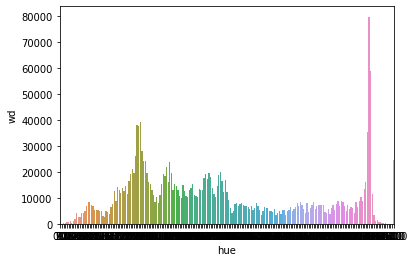

In [19]:
# 将数据转换成DataFrame 
df = pd.DataFrame(pixel_counter.most_common(), columns=['color', 'wd']) 
 
# 提取颜色中的HSV值 
df['hue'] = df.color.apply(lambda x: x[0]) 
df['saturation'] = df.color.apply(lambda x: x[1]) 
df['value'] = df.color.apply(lambda x: x[2])
#由于convert之后，im_hsv依然是0-255范围，需要将其分别处理成hue(0~360), saturation(0~1), value(0~1)

# 使用scikit-learn工具进行预处理 
from sklearn.preprocessing import MinMaxScaler 
hue_scaler = MinMaxScaler((0,360)) 
scaler_01 = MinMaxScaler() 
 
df['hue'] = hue_scaler.fit_transform(df[['hue']]) 
df['saturation'] = scaler_01.fit_transform(df[['saturation']]) 
df['value'] = scaler_01.fit_transform(df[['value']]) 
 
# 小数点处理 
df.hue = df.hue.round(0) 
df.saturation = df.saturation.round(2) 
df.value = df.value.round(2) 
 
df.head()
#查看颜色、饱和度、明度的数据分布
hue_df = pd.DataFrame(df.groupby('hue').wd.sum()) 
hue_df = hue_df.reset_index() 
sns.barplot(data=hue_df, x="hue", y="wd")

<AxesSubplot:xlabel='value', ylabel='wd'>

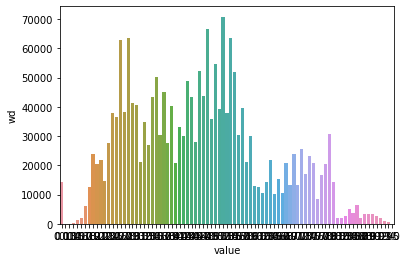

In [20]:
value_df = pd.DataFrame(df.groupby('value').wd.sum()) 
value_df.reset_index(inplace=True) 
sns.barplot(data=value_df, x="value", y="wd")

<AxesSubplot:xlabel='saturation', ylabel='wd'>

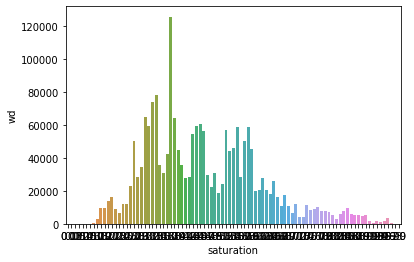

In [21]:
satur_df = pd.DataFrame(df.groupby('saturation').wd.sum()) 
satur_df.reset_index(inplace=True) 
sns.barplot(data=satur_df, x="saturation", y="wd")